In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB


### Introduction

Below is an implementation of Naive Bayes classifier that can recommend the best options to maximise Facebook posts' performance.

The input features are:

* post_type:	Link, Photo, Status, Video
* category:	1: action (special offers and contests) 2: product (direct advertisement and explicit brand content) and 3: inspiration (non-explicit brand related content)
* paid	paid, unpaid
* weekday
* hour	


The performance metrics are:

* Lifetime Post Total Reach
* Lifetime Post Total Impressions
* Lifetime Engaged Users
* Lifetime Post Consumers
* Lifetime Post Consumptions
* Lifetime Post Impressions by people who have liked your Page
* Lifetime Post reach by people who like your Page
* Lifetime People who have liked your Page and engaged with your post
* comment
* like
* share
* Total Interactions

Details of the metrics can be found [here](http://www.math-evry.cnrs.fr/_media/members/aguilloux/enseignements/moro2016.pdf).

The algorithm accepts questions in the format of:

* I want to make a post with these features fixed e.g., a paid photo.
* And I want to optimise this metric e.g., shares
* What is by best option for these features? e.g., weekday and hour

The algorithm returns a answer with the expected relative performance of each option

And there is a graphing function to display the top three







## Read and process the data

In [3]:
# read the data
df = pd.read_csv('dataset_Facebook.csv', sep=';')

# upate header names
header_lookup_df = pd.read_csv('header_lookup.csv')


columns = {}
describe = {}

for index, row in header_lookup_df.iterrows():
    columns[row.source] = row.target
    describe[row.target] = row.description

df.rename(index=str, columns=columns, inplace=True)



#drop the 5 rows with na
df.dropna(inplace=True)

# change paid from float to integer
df.paid = df.paid.astype(int)

# change post type from string to integer
type_int = {'Photo': 1, 'Link': 2, 'Status': 3, 'Video': 4}
df.replace(type_int, inplace=True)



   
df.head()

,page_total_likes,post_type,category,month,weekday,hour,paid,reach_users,impressions,engaged_users,consumers,consumptions,impressions_liked,reach_liked,engaged_liked,comment,like,share,total_interactions
0,139441,1,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,3,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,1,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,1,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,1,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


## Cross validate the model

In [10]:

# define a function that cross validates the model
def evaluate_model(df, features, target):
    
    # the model takes a dataframe of with the feature columns and target metric    

    # remove columns we don't need
    df = df.loc[df.index, features+[target]]
    
    # change the target to a uniform distribution of quintliles
    df['uniform'] = df[target].rank() / len(df) * 4 + 1
    df['uniform'] = df.uniform.round().astype(int)
    
    # write data to matrix
    raw_X = df.as_matrix(df.columns[:-2])
    y = df.as_matrix(df.columns[-1:]).flatten()
        
    # transform to one hot matrix
    enc = OneHotEncoder(sparse=False)
    enc.fit(raw_X)  
    X = enc.transform(raw_X)
    
    # arrays to store error results
    mean_err = []
    var_err = []
    
    # number of cross validation runs
    runs = 1000
    
    for i in range(runs):
    
        # split into test and train 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

        # train the model
        clf = BernoulliNB()
        clf.fit(X_train, y_train)

        # evaluate the model
        y_pred= clf.predict(X_test)

        err = y_pred - y_test
        
        mean_err.append(err.mean())
        var_err.append(err.var())

        #print('mean error: {:.1f}, standard deviation: {:.1f}, variance: {:.1f}'.format(err.mean(), err.std(), err.var()))
    
    print('After {} runs, average standard deviation of error: {:.1f}'.format(runs, np.mean(var_err)**0.5))
    print()
    
    # plot the last runs distribution of errors as an example
    sns.set(style="white", context="talk")
    ax = sns.kdeplot(err, shade=True)
    ax.set_xlim(-5,5)
    ax.set_xlabel('error size (quintiles)')
    ax.set_yticks([])
    ax.set_title('Error Distribution')
    sns.despine(left=True)
    plt.show()
    print('-ve values when prediction is too low')
    print('a random guesser would get a standard deviation of 2')
    
    

After 1000 runs, average standard deviation of error: 1.2



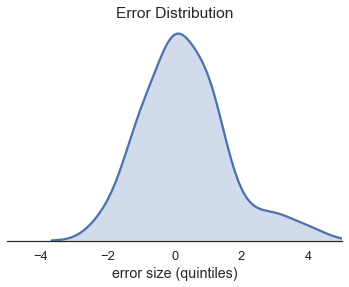

-ve values when prediction is too low
a random guesser would get a standard deviation of 2


In [23]:
# evaluate the model

# the output metric we are predicting
target = 'consumers'

# the input features we want to include
features = ['category', 'post_type', 'paid', 'weekday', 'hour']

# use the pandas api to drill down the input dataframe to evalute performance for specific subsets
input_df = df[df.category==2]

# call the evaluation function - 
evaluate_model(input_df, features, target)

In [24]:
# define a function to accept question objects and return best options

def answer(df, question):
    
    # accepts a data frame with the features and target
    # and a question object
    # the question object has a target key
    # and a feature key
    
    # the feature key has a dictionary of features
    # each feature can either be 
    # True - if you want to ask what the optimal value for the feature is
    # String - if you already know what value you want for the feature
    # False - if you want to ignore the feature
    
    # the function returns and object with
    # the "target"
    # the "given" feature values that were set True
    # the "features" that were being optimised
    # and a results dataframe with
    # all unique combinations of to testing features
    # the most likeyly quintile for the combination
    # the probabilities of each quintile for the combination
        
    # look up dictionary    
    lookup = {
        'category': {
            'map': {'action': 1, 'product': 2, 'inspiration': 3},
            'reverse': {1: 'action', 2: 'product', 3: 'inspiration'}
        },
        'paid': {
            'map': {'unpaid': 0, 'paid': 1},
            'reverse': {0: 'unpaid', 1: 'paid'}
        },
        'post_type': {
            'map': {'Photo': 1, 'Link': 2, 'Status': 3, 'Video': 4},
            'reverse': {1: 'Photo', 2: 'Link', 3: 'Status', 4: 'Video'}
        },
        'weekday': {
            'map': {'Sun': 1, 'Mon': 2, 'Tue': 3, 'Wed': 4, 'Thur': 5, 'Fri': 6, 'Sat':7},
            'reverse': {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thur', 6: 'Fri', 7: 'Sat'}
        }, 
        'hour': {
            'map': dict(enumerate(range(24))),
            'reverse': dict(enumerate(range(24)))            
        }
    }

    # performance metric to compare
    target = question['target']
   
    # features to compare
    features = []
    
    # given these features are fixed
    fixed = []
    
    # interpret the question object
    for f in question['feature']:          
        
        val = question['feature'][f]
        
        # if feature is true include it in the model
        if val == True:
            features.append(f)
            
        # if feature is false exlcude it from the model        
        elif val == False:
            pass
        
        # if the feature is a string filter the data for the value 
        else:
            # test the value is valid during filter step
            try:
                df = df[df[f]==lookup[f]['map'][val]]
                # if valid add to fixed
                fixed.append('{}: {}'.format(f, val))
            except Exception as e: 
                print('invalid question {}, {}'.format(f, val))
                print(e)
            
    
    # remove columns we don't need
    df = df.loc[df.index, features+[target]]

    # change the target to a uniform distribution of quintliles
    df['uniform'] = df[target].rank() / len(df) * 4 + 1
    df['uniform'] = df.uniform.round().astype(int)
    
    # write data to matrix
    raw_X = df.as_matrix(df.columns[:-2])
    y = df.as_matrix(df.columns[-1:]).flatten()
    

    # transform to one hot matrix
    enc = OneHotEncoder(sparse=False)
    enc.fit(raw_X)  
    X = enc.transform(raw_X)

    # train the model
    clf = BernoulliNB()
    clf.fit(X, y)
    
    
    # get dataframe of possible states
    quest_df = df[df.columns[:-2]].drop_duplicates()
    
    # write data to matrix
    quest_X = quest_df.as_matrix()
    
    # turn quest_df back into human readable form for results dataframe
    answer_df = pd.DataFrame()
    for f in features:
        answer_df[f] = quest_df[f].replace(lookup[f]['reverse'])
    
    
    # make predictions
    y_pred = clf.predict(enc.transform(quest_X))
    y_prob =  clf.predict_proba(enc.transform(quest_X))
    
    # save results to dataframe
    answer_df['res'] = y_pred
    answer_df['probs'] = (y_prob * 100).tolist()
    

    return {'target': target, 'given': fixed, 'features': features, 'res': answer_df}



In [25]:
# define function to plot top results

def plot_answer(ans, top=3):
    
    # get top results
    df = ans['res'].sort_values('res', ascending=False).head(top).reset_index(drop=True)
    
    sns.set(style="white", context="talk")

    f, ax = plt.subplots(1, top, figsize=(12,4), sharex=True, sharey=True)

    x = [1, 2, 3, 4, 5]  
    
    for i, row in df.iterrows():
          
        y = row.probs
        label = " ".join(map(str, list(row.iloc[:-2])))
        ax[i] = sns.barplot(x, y, palette="RdYlGn", ax=ax[i])
        ax[i].set_title(label)

    ax[1].set_xlabel('expected {} quintile - 5 is best'.format(ans['target']))
    ax[0].set_ylabel('probability %')

    plt.suptitle('Top {} choices, given: {} \n\n Choosing from: {}'.format(top, ', '.join(ans['given']), ', '.join(ans['features'])), y=1.2)

    sns.despine(left=True)
    
    plt.show()



## Below we ask two questions

First I want to post a product (direct advertisement or explicit brand content) and maximise consumers

*“Should I post  a status update, photo, link or video; and it should be paid or unpaid?”*


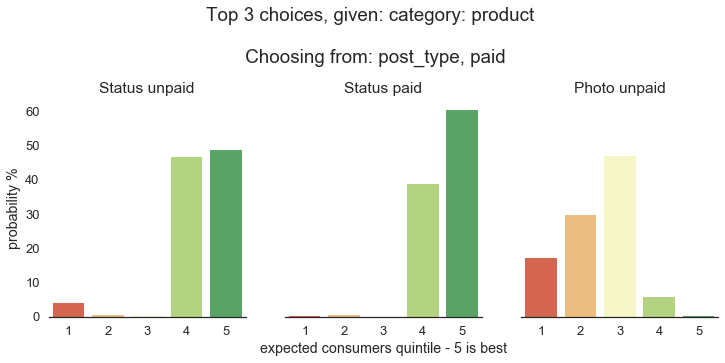

In [26]:
question = {
    'feature': {
        'category': 'product',
        'post_type': True,
        'paid': True,
        'weekday': False,
        'hour': False
    },
    'target': 'consumers'
}         

ans = answer(df, question)
plot_answer(ans)

The answer is: *Status updates are best for product post and paid is slightly better than unpaid.*

Next we ask: *If I decide on a paid status update, when is the best time to post?*

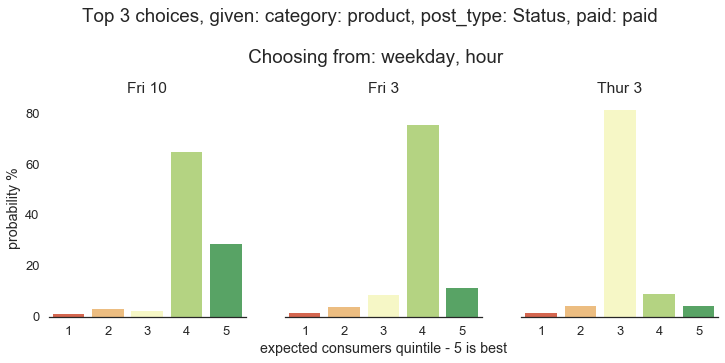

In [27]:
question = {
    'feature': {
        'category': 'product',
        'post_type': 'Status',
        'paid': 'paid',
        'weekday': True,
        'hour': True
    },
    'target': 'consumers'
}         

ans = answer(df, question)

plot_answer(ans)

And we get back the answer: *The best time is either Friday at 10 or 3* [unknown timezone :( ]